# Map_Cities.ipynb
2021.02.23

In [1]:
# Map_Cities.ipynb
# check sanity of dist and angle calculation formulas
# 2021.02.23
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:93% !important; }</style>"))

In [2]:
import matplotlib.pyplot as plt
import folium
import os
# import json
import numpy as np

import math
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Prapare mapping locations for scatter plots
* Given a DF $d$ with multiple rows of mapping data points, we want to build a 2D scatter plot of these points.
* Mapping coordinates are given as  **latitude** and **longitude** in degrees.

* When shown on a map usually we have to specify **(latitude, longitude)**, however for 2D scatter plots with XY-coordinates we need to switch the order, i.e. **(Xcoord = longitude,    Ycoord = latitude)**.

* Distance between any two points $P_1(lat_1, long_1)$ and $P_2(lat_2, long_2)$ is being computed using **haversine_deg2m( lat1, long1 ,   lat2, long2 )** function.

* For 2D scatter plots we may want to specify a center point $C = (C_x,C_y) = (Cx\_longitude,    Cy\_latitude)$.

* Given a point $P$ with coordinates $(Xlongitude, Ylatitude)$ we can compute **relative** X and Y coordinates of each point $P$: **( X = Xlongitude - Cx_longitude, Y = Ylatitude - Cy_latitude )**.

* Observe that  $X>0 \iff Xlongitude > Cx\_longitude \iff $  $P$ is to the RIGHT HAND SIDE of the Center Point $C$.

        [Cx_long, Cy_lat] = get_Center_coord_deg_XY(d)
        dist_m_hav = haversine_degrees_to_dist_m( Cy_lat, Cx_long,   Py_lat, Px_long )
        X = Px_long - Cx_long     
        Y = Py_lat  - Cy_lat      
* For each $P$ compute angle 
$\displaystyle \alpha = \arccos(  \frac{ \overrightarrow{u}\cdot \overrightarrow{v}  }{ \lVert \overrightarrow{v} \rVert }  )$ 
between the north pointing vector $\overrightarrow{u}=(0,1)$ and vector $\overrightarrow{v}=\overrightarrow{CP} = \overrightarrow{OP} - \overrightarrow{OC}$. 
          
        vec_CP = np.array( d[ ['x_long','y_lat' ] ].copy() ) - [Cx_long, Cy_lat]
        unit_vec_CP =  vec_CP / np.linalg.norm(vec_CP, axis=1)[:,numpy.newaxis]
        unit_vector_north = [0,1] 
        angle_rad = np.sign(  unit_vec_CP[:,0]  )*(np.arccos( np.dot( unit_vec_CP,  unit_vector_north )))
        angle_deg = np.rad2deg(angle_rad)

        xm = dist_m_hav * np.cos(np.pi/2 - angle_rad)
        ym = dist_m_hav * np.sin(np.pi/2 - angle_rad)

* [Haversine formula calculates the great-circle distance between two points](https://en.wikipedia.org/wiki/Haversine_formula)

        def haversine_deg2m(   lat1_deg, long1_deg,   
                               lat2_deg, long2_deg ):   #**kwarg):
            """  https://en.wikipedia.org/wiki/Haversine_formula
            Haversine formula calculates the great-circle distance between two points – that is, 
            the shortest distance over the earth’s surface – giving an ‘as-the-crow-flies’ distance between the points 
            (ignoring any hills they fly over, of course!).
            Haversine formula:    a = sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2)
                                  c = 2 ⋅ atan2( √a, √(1−a) )
                                  d = R ⋅ c
            where   φ is latitude, λ is longitude, R is earth’s radius (mean radius = 6,371km);
            note that angles need to be in radians to pass to trig functions!
            """
            R = 6371.0088
            lat1_rad  = np.deg2rad(lat1_deg)
            lat2_rad  = np.deg2rad(lat2_deg)
            dlat      = lat2_rad - lat1_rad

            ''' the next three lines are repalced by 4th lind. This speeds up the function by 5-7% 
                2.51  / 2.34 = 1.07
                25.1 /  23.9 = 1.05     '''
            #     long1_rad = np.deg2rad(long1_deg)
            #     long2_rad = np.deg2rad(long2_deg)
            #     dlong     = long2_rad - long1_rad    
            dlong     = np.deg2rad(long2_deg - long1_deg)

            a = np.sin(dlat/2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlong/2) **2
            c = 2 * np.arctan2(a**0.5, (1-a)**0.5)
            d = R * c
            return d        
            
* SANITY CHECK:

            lyon = [45.7597, 4.8422] # (lat, long)
            paris = [48.8567, 2.3508]
            new_york = [40.7033962, -74.2351462]
            haversine_deg2m(  lyon[0], lyon[1], paris[0], paris[1]  ) # 392.2 km
            haversine_deg2m( new_york[0], new_york[1],  paris[0], paris[1]  ) # 5853.3 km    google:5,834 km
            

In [3]:
#===========================================================================
#========= COMPUTE DISTANCE AND ANGLE
#===========================================================================

# angle degree should also be between [-180,180] relative to azimuth
# angle in radians should also be between [-pi,pi] relative to azimuth
# NOTE: to compute (x,y), (xm,ym) and distance to the Center we can 
#       specify the Center coordinates: antX_long, antY_long	
# If they are not specified (NaN by default), then we pool them and antenna coordinates in d
def compute_xy_dist_and_angle_FOR_CITIES(d, antX_long=math.nan, antY_lat=math.nan):
    if math.isnan(antX_long) | math.isnan(antY_lat):
        [antX_long, antY_lat] = get_antenna_coord_deg_XY(d)
        
#     ue_ant_m_hav      = haversine_degrees_to_dist_m(      antY_lat,              antX_long,   
#                                                           d['end_location_lat'], d['end_location_lon'] )
    ue_ant_m_hav      = haversine_deg2m(   antY_lat,              antX_long,   
                                                          d['end_location_lat'], d['end_location_lon'] )
    
    d['x'] = d['end_location_lon'] - antX_long     #rap['antenna_longitude_degrees_nad83']
    d['y'] = d['end_location_lat'] - antY_lat      #rap['antenna_latitude_degrees_nad83']
    
    vec_Antenna_UE = np.array( d[  ['end_location_lon','end_location_lat' ] ].copy() ) - [antX_long, antY_lat]
    unit_vec_Antenna_UE =  vec_Antenna_UE / np.linalg.norm(vec_Antenna_UE, axis=1)[:,np.newaxis]
    unit_vector_north = [0,1]  # north 
    angle_deg = np.sign(  unit_vec_Antenna_UE[:,0]  )*(np.arccos( np.dot( unit_vec_Antenna_UE,  unit_vector_north )))/np.pi*180
    angle_rad = np.deg2rad(angle_deg)

    d['xm'] = ue_ant_m_hav * np.cos(np.pi/2 - angle_rad)
    d['ym'] = ue_ant_m_hav * np.sin(np.pi/2 - angle_rad)

    d['ue_ant_m_hav']        =          ue_ant_m_hav
    d['log10_ue_ant_m_hav']  = np.log10(ue_ant_m_hav)

    d['ue_angle_rad']   =          angle_rad
    d['ang_rad_sq']     = np.power(angle_rad, 2)
    d['ue_angle_deg']   = np.round(angle_deg, 1)

    return d        


''' SANITY CHECK:
lyon = [45.7597, 4.8422] # (lat, long)
paris = [48.8567, 2.3508]
new_york = [40.7033962, -74.2351462]
d1=haversine_deg2m(  lyon[0], lyon[1], paris[0], paris[1]  ) # 392.2 km
d2=haversine_deg2m( new_york[0], new_york[1],  paris[0], paris[1]  ) # 5853.3 km    google:5,834 km
# print(d1,d2)
'''


#===========================================================================
def haversine_deg2m(   lat1_deg, long1_deg,   
                       lat2_deg, long2_deg ):   #**kwarg):
    """  https://en.wikipedia.org/wiki/Haversine_formula
    Haversine formula calculates the great-circle distance between two points – that is, 
    the shortest distance over the earth’s surface – giving an ‘as-the-crow-flies’ distance between the points 
    (ignoring any hills they fly over, of course!).
    Haversine formula:    a = sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2)
                          c = 2 ⋅ atan2( √a, √(1−a) )
                          d = R ⋅ c
    where   φ is latitude, λ is longitude, R is earth’s radius (mean radius = 6,371km);
    note that angles need to be in radians to pass to trig functions!
    """
    R = 6371.0088
    lat1_rad  = np.deg2rad(lat1_deg)
    lat2_rad  = np.deg2rad(lat2_deg)
    dlat      = lat2_rad - lat1_rad

    ''' the next three lines are repalced by 4th lind. This speeds up the function by 5-7% 
        2.51  / 2.34 = 1.07
        25.1 /  23.9 = 1.05     '''
    long1_rad = np.deg2rad(long1_deg)
    long2_rad = np.deg2rad(long2_deg)
    dlong     = long2_rad - long1_rad    
#     dlong     = np.deg2rad(long2_deg - long1_deg)
    
    a = np.sin(dlat/2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlong/2) **2
    c = 2 * np.arctan2(a**0.5, (1-a)**0.5)
    d_m = 1000*R * c  # dist in meters
    return d_m

In [4]:



def get_city_map(  Center_LatY_LongX ,                                   #[ 33.080194, -96.755964 ], <= PALNO 
                  Radius_m ,
                  d, 
                 startting_zoom = 4,
                  icon_dir= ' ', 
                  city_color =['red'] ):
    # Create custom marker icons
    CenterIcon = folium.features.CustomIcon( icon_dir+'icons/cell_tower.png',       icon_size=(30, 30))
    cityIcon    = folium.features.CustomIcon( icon_dir+'icons/mobile-alt-solid.svg', icon_size=(50, 50))
    city_locs = d[ ['latitude','longitude'] ].copy()
        
    # Create map object
    m = folium.Map(location=Center_LatY_LongX, zoom_start=startting_zoom)
    # Place TARGET / Center Icon
    folium.Marker( Center_LatY_LongX,
                  popup='<strong>Location Five</strong>',
                  tooltip = str(Center_LatY_LongX),
                  icon    = CenterIcon         ).add_to(m)    
    
    # Place ICONS
    for k in range( len(d) ):
        folium.Marker( location = np.array(city_locs.iloc[k]), 
                       tooltip = d.city[k] + f'; dist={  int(tx["ue_ant_m_hav"][k]/1000)}km, angle={tx["ue_angle_deg"][k]} '  ,
                       icon=folium.Icon(color= city_color[0], 
                                   icon = 'brodcast-tower' ,prefix='fa',
                                  )).add_to(m)
    
    # Circle marker
    folium.CircleMarker(
        location = Center_LatY_LongX,
        radius = 50,
        popup= 'Target_Center',
        color='#428bca',
        fill=True,
        fill_color='#428bca'
    ).add_to(m)

    folium.Circle(
        location = Center_LatY_LongX,
        radius = Radius_m,
        popup= 'Target_Center',
        color='red',
        fill=True,
        fill_color='#428bca'
    ).add_to(m)
    

    return m

In [5]:
cities = ['Dallas, 32.779167, -96.808891',
    'Plano, 33.019844, -96.698883',
    'Fort Worth, 32.768799, -97.309341',
    'Greenville, 33.1384488, -96.1108066',
    'Denton, 33.2148412, -97.1330683',
    'Frisco, 33.155373, -96.818733',
    'Irving, 32.819595, -96.945419',
    'Flower Mound, 33.014568, -97.096954',
    'Royse City, 32.9743, -96.3328']

In [6]:
# Latitude 
[ float(cities[k].split(',')[1].strip())  for k in range(len(cities)) ]

[32.779167,
 33.019844,
 32.768799,
 33.1384488,
 33.2148412,
 33.155373,
 32.819595,
 33.014568,
 32.9743]

In [7]:
tx = pd.DataFrame(  {'city' :    [cities[k].split(',')[0] for k in range(len(cities))], 
                     'end_location_lat'  :   [ float(cities[k].split(',')[1].strip())  for k in range(len(cities)) ],
                     'end_location_lon'  :   [ float(cities[k].split(',')[2].strip())  for k in range(len(cities)) ]   }  )

tx=compute_xy_dist_and_angle_FOR_CITIES( d=tx, antX_long=tx.end_location_lon[0], antY_lat=tx.end_location_lat[0]  )
tx.xm[0]=0
tx.ym[0]=0

col_map     = { 'latitude': 'end_location_lat',  'longitude': 'end_location_lon' }
col_map_rev = { 'end_location_lat': 'latitude',  'end_location_lon': 'longitude' } 
tx = tx.rename(columns=col_map_rev)
tx

<ipython-input-3-324045a3f371>:23: RuntimeWarning: invalid value encountered in true_divide
  unit_vec_Antenna_UE =  vec_Antenna_UE / np.linalg.norm(vec_Antenna_UE, axis=1)[:,np.newaxis]
<ipython-input-3-324045a3f371>:25: RuntimeWarning: invalid value encountered in sign
  angle_deg = np.sign(  unit_vec_Antenna_UE[:,0]  )*(np.arccos( np.dot( unit_vec_Antenna_UE,  unit_vector_north )))/np.pi*180
C:\Users\khafifa\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-7-c573dfb5d537>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tx.xm[0]=0
<ipython-input-7-c573dfb5d537>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in th

,city,latitude,longitude,x,y,xm,ym,ue_ant_m_hav,log10_ue_ant_m_hav,ue_angle_rad,ang_rad_sq,ue_angle_deg
0,Dallas,32.779167,-96.808891,0.000000,0.000000,0.000000,0.000000,0.000000,-inf,NaN,NaN,NaN
1,Plano,33.019844,-96.698883,0.110008,0.240677,11916.428423,26070.924329,28665.211698,4.457355,0.428724,0.183804,24.6
2,Fort Worth,32.768799,-97.309341,-0.500450,-0.010368,-46793.295271,-969.433281,46803.336240,4.670277,-1.591511,2.532906,-91.2
3,Greenville,33.138449,-96.110807,0.698084,0.359282,67937.231236,34965.128465,76406.986569,4.883133,1.095483,1.200083,62.8
4,Denton,33.214841,-97.133068,-0.324177,0.435674,-34088.784506,45813.213691,57104.253588,4.756668,-0.639703,0.409220,-36.7
5,Frisco,33.155373,-96.818733,-0.009842,0.376206,-1094.271154,41828.020092,41842.331367,4.621616,-0.026155,0.000684,-1.5
6,Irving,32.819595,-96.945419,-0.136528,0.040428,-12972.791235,3841.439148,13529.595972,4.131285,-1.282907,1.645852,-73.5
7,Flower Mound,33.014568,-97.096954,-0.288063,0.235401,-29060.686863,23747.981338,37529.856629,4.574377,-0.885664,0.784400,-50.7
8,Royse City,32.974300,-96.332800,0.476091,0.195133,45776.482326,18762.174302,49472.270199,4.694362,1.181815,1.396686,67.7


In [8]:
Center_LatY_LongX = [  tx.latitude[0], tx.longitude[0]  ]
m=get_city_map(  Center_LatY_LongX = Center_LatY_LongX,                                   #[ 33.080194, -96.755964 ], <= PALNO 
                  Radius_m = 20000,
                  d=tx, 
               startting_zoom = 10,
                  icon_dir= r'G:\My Drive\__C\Users\khafifa\Downloads\data\pyviz/',
                  city_color =['red'] )
m

In [9]:
# print(tx.columns)
# tx

In [10]:
def do_scatter_plot_cities(d, ttl):
    plt.rcParams['figure.figsize'] = [ 14, 14 ]
    plt.rcParams.update({'font.size': 14})
    fig, ax = plt.subplots()
    x = d['xm']
    y = d['ym']

    ax.scatter(x,y, c='red', s=500, alpha=0.2)
    ax.scatter(0,0, c='blue', s=800, alpha=0.2)
    ax.grid(True)   
    # https://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point
    # for i, txt in enumerate(d.shape[0]):
    for k in range(d.shape[0]):
        prompt = d.city[k] + f'; dist={  int(tx["ue_ant_m_hav"][k]/1000)}km, angle={tx["ue_angle_deg"][k]} ' 
        ax.annotate(  prompt, ( x[k], y[k]))

    plt.title( ttl )
    plt.show()

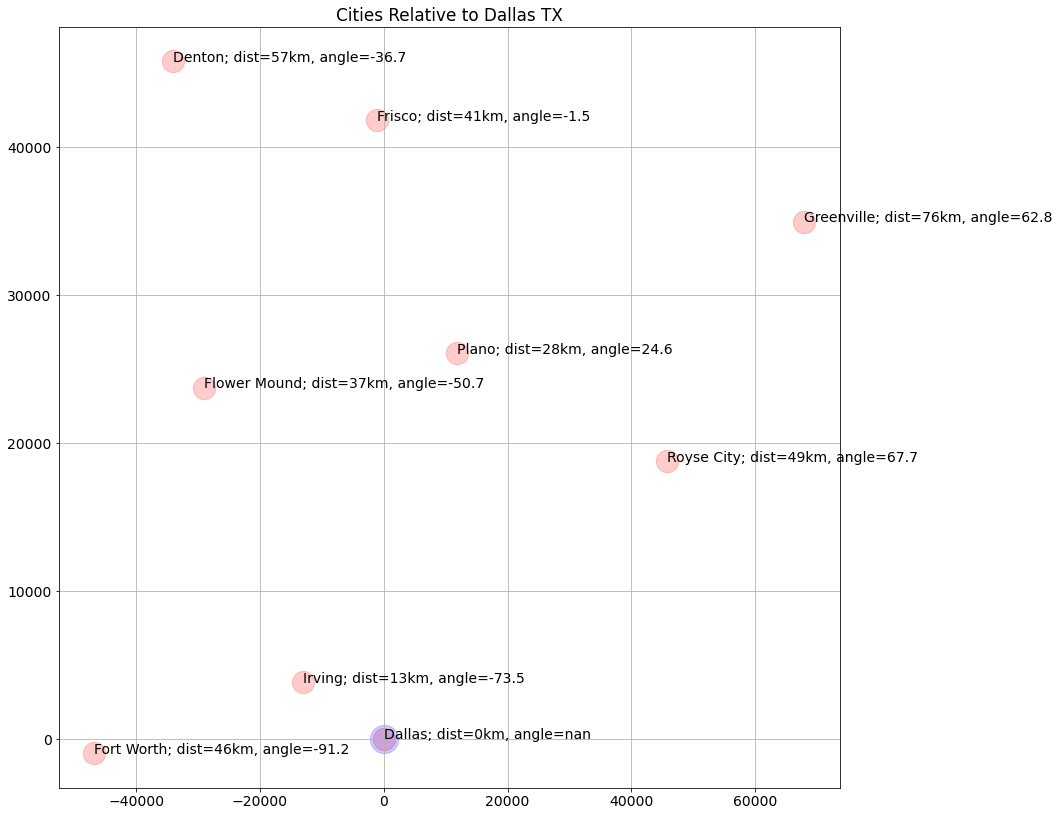

In [11]:
do_scatter_plot_cities(d=tx, ttl='Cities Relative to Dallas TX')